# Creación y Evaluación de Modelos 

- Análisis de Ciencias de Datos
- TC2004B.100
- Profesores:
  - Daniel Otero Fadul
  - Rubí Isela Gutiérrez López
- Equipo 4:

| Nombre | Matrícula |
| ---- | ---- |
| Juan Pablo Echeagaray González | A00830646 |
| Emily Rebeca Méndez Cruz | A00830768 |
| Eugenio Santisteban Zolezzi | A01720932 |
| Taurino López González | A01284076 |
| Ricardo de Jesús Balam Ek | A00831262 |
| Grace Aviance Silva Aróstegui | A01285158 |

Fecha: 17 de marzo del 2022

## Propósito

Para esta actividad realizarás la creación y evaluación de modelos utilizando los datos que procesaste y analizaste en la actividad anterior.

## Instrucciones

Implementarás dos o más modelos de "machine learning" que consideres relevantes para tu proyecto y los evaluarás utilizando algunas de las métricas vistas en clase. A parte del código que deberás escribir, también se requiere que junto con este, escribas un reporte en el cual describas los pasos que vas realizando en el proceso y finalizar con unas conclusiones en las que hables de tus hallazgos.

Por cierto, esta entrega es revisada por UNICHECK. Dicho esto, todo su trabajo debe ser de su autoría. Si incluyen código o texto que no sea escrito por ustedes debe citarse la fuente.

## Dependencias

In [1]:
# Dependencias básicas
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Tratamiento de variables, selección de variables, entrenamiento de modelos predictivos
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Versiones de librerías utilizadas
print(f'''Paquetes utilizados:
- python: {sys.version}
- numpy: {np.__version__}
- pandas: {pd.__version__}
- matplotlib: {mpl.__version__}
- seaborn: {sns.__version__}
- sklearn: {sklearn.__version__}''')


Paquetes utilizados:
- python: 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
- numpy: 1.22.2
- pandas: 1.1.4
- matplotlib: 3.4.1
- seaborn: 0.11.1
- sklearn: 1.0.2


## Lectura de datos

El archivo que tomaremos como base de datos para el proceso de entrenamiento de modelos será la base de datos que hemos limpiado en la etapa anterior.

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head()


,Country,Consultant,Opportunity ID,Account,ISBN 13,Author,Title,Probability,% de Avance,Term,...,Units,Revenue,Technology,Course Name,Edition,Course ID,Customer,Client,Log Revenue,Coded Probability
0,Mexico,14,5255970,colegio de bachilleres de chihuahua,9.786075e+12,martinez,literatura ii,No_Aceptada,1.00,2021-08-01,...,8929,1308277.08,Copia física,literatura cobach,1.0,1847125,Potential Customer,3705,14.084222,0.00
1,Mexico,10,5172372,u-erre universidad regiomontana,9.781338e+12,serway/vuille,intl iac wa fundamentos de fis ica,Closed Sale,1.00,2021-01-01,...,22,1161600.00,WebAssign,fisica 1 prepa u-erre,11.0,1905363,Potential Customer,3681,13.965309,1.00
2,Mexico,6,4496314,itesm campus monterrey,9.786075e+12,cengage,biblioteca digital magellan,No_Aceptada,1.00,2020-09-01,...,2,779999.95,Copia física,biblioteca digital,1.0,1873177,Potential Customer,5929,13.567049,0.00
3,Mexico,0,5745690,unitec campus cuitlahuac,9.786076e+12,galindo,modelos de organización,Evaluation Visit,0.75,2022-05-01,...,2000,600000.00,Copia física,estructuras organizacionales y gestión del con...,1.0,1934416,Potential Customer,2538,13.304685,0.75
4,Mexico,0,5745686,unitec campus cuitlahuac,9.786076e+12,galindo,modelos de organización,Evaluation Visit,0.75,2022-01-01,...,2000,600000.00,Copia física,estructuras organizacionales y gestión del con...,1.0,1934416,Potential Customer,2538,13.304685,0.75


## Selección de variables

### OneHotEncoding para variables categóricas

In [3]:
tech_types = df['Technology'].unique()
tech_dum = pd.get_dummies(df, columns=['Technology'], prefix=['Tech_'])


In [4]:
countries = tech_dum['Country'].unique()
country_dum = pd.get_dummies(tech_dum, columns=['Country'], prefix=['Country_'])


In [5]:
# Get added columns from df and country_dum
df_cols = df.columns
country_dum_cols = country_dum.columns
added_cols = country_dum_cols.difference(df_cols)
print(f'''Diferencia de columnas
# de columnas nuevas: {len(added_cols)}
Columnas añadidas: {added_cols}''')


Diferencia de columnas
# de columnas nuevas: 20
Columnas añadidas: Index(['Country__Colombia', 'Country__Costa Rica',
       'Country__Dominican Republic', 'Country__Ecuador',
       'Country__El Salvador', 'Country__Guatemala', 'Country__Honduras',
       'Country__Mexico', 'Country__Nicaragua', 'Country__Panama',
       'Tech__CengageNOW', 'Tech__CengageNOWv2', 'Tech__Copia física',
       'Tech__MindTap', 'Tech__MindTap - MT4', 'Tech__MindTap with LivePlan',
       'Tech__MyELT', 'Tech__OWLv2', 'Tech__Other Digital', 'Tech__WebAssign'],
      dtype='object')


Al final del proceso acabamos con 20 variables nuevas, hemos de destacar desde esta etapa que el número de variables es grande. El usar todas podría hacer que los modelos que entrenemos sean en exceso complejos, quitándoles la habilidad de generalizar a nuevos datos.

In [6]:
test_cols = ['Consultant', 'Coded Probability', 'Edition', 'Seats', 'Units', 'Tech__CengageNOW',
       'Tech__CengageNOWv2', 'Tech__Copia física', 'Tech__MindTap',
       'Tech__MindTap - MT4', 'Tech__MindTap with LivePlan', 'Tech__MyELT',
       'Tech__OWLv2', 'Tech__Other Digital', 'Tech__WebAssign', 'Country__Colombia', 'Country__Costa Rica',
       'Country__Dominican Republic', 'Country__Ecuador',
       'Country__El Salvador', 'Country__Guatemala', 'Country__Honduras',
       'Country__Mexico', 'Country__Nicaragua', 'Country__Panama']


## Creación de conjuntos de datos

Un primer paso que debemos de tomar es la estandarización de datos. Los modelos regresores trabajan mejor cuando todas las variables tienen rangos similares, esto ayuda a reducir la dominancia que podría tomar una variable que tenga un rango en órdenes de magnitud de miles contra otra que trabaja con valores de 0 a 1 por ejemplo.

Para realizar esta tarea hacemos uso del estandarizador de datos de `scikit-learn`

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(country_dum[test_cols])


In [8]:
y = country_dum['Log Revenue']
X = country_dum[test_cols]
X_2 = scaled_data


In [9]:
# Datos normales
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [10]:
# Datos estandarizados
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y, random_state=0)


## Probando modelos

Para nuestra investigación, hemos decidido utilizar modelos de regresión para predecir el `Revenue` generado dada una operación. Como posibles candidatos tenemos varios modelos de regresión lineal, entre ellos están la simple, ridge y lasso; y al árbol de decisión en su modalidad regresora. Como métricas de comparación se usarán el coeficiente de determinación y el error cuadrático medio.

Como punto de referencia, se desea que el coeficiente de determinación (`r2`) sea lo más cercano posible a 1, y el error cuadrático medio debe de ser lo más cercano a 0 que se pueda. Se incluirá también el puntaje en el conjunto de prueba como un dato extra. Su valor siempre será superior al coeficiente de determinación, pero de cualquier manera sirve para comparar de antemano como se comportan los modelos con datos que ya vieron.

Los modelos y métricas a usar son aquellos implementados en la librería de `scikit-learn`, estándar en la comunidad de ciencias de datos.

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
results_df = pd.DataFrame(columns=['Model', 'Train Score', 'MSE', 'R2'])


In [12]:
def report(model_name: str,fun_model: callable, X_train, X_test, y_train, y_test):
    # Función auxiliar que genera un diccionario con las principales métricas de un modelo
    y_pred = fun_model.predict(X_test)
    return {'Model': model_name, 'Train Score': fun_model.score(X_train, y_train), 
        'MSE': mean_squared_error(y_test, y_pred), 'R2': r2_score(y_test, y_pred)}


### Árboles de decisión regresores

In [13]:
my_tree = DecisionTreeRegressor(max_depth=9, random_state=0)
my_tree.fit(X_train, y_train)

results_df = results_df.append(report('Árbol Regresor', my_tree, X_train, X_test, y_train, y_test), ignore_index=True)


In [14]:
tree_2 = DecisionTreeRegressor(max_depth=9, random_state=0)
tree_2.fit(X_train2, y_train2)

results_df = results_df.append(report('Árbol Regresor Estandarizado', tree_2, X_train2, X_test2, y_train2, y_test2), ignore_index=True)


### Regresión lineal

In [15]:
lrg = LinearRegression()
lrg.fit(X_train, y_train)

results_df = results_df.append(report('Regresor Lineal', lrg, X_train, X_test, y_train, y_test), ignore_index=True)


### Regresión Ridge

In [16]:
ridge = Ridge(alpha=0.2)
ridge.fit(X_train, y_train)

results_df = results_df.append(report('Ridge', ridge, X_train, X_test, y_train, y_test), ignore_index=True)


In [17]:
ridge2 = Ridge(alpha=0.2)
ridge2.fit(X_train2, y_train2)

results_df = results_df.append(report('Ridge Estandarizado', ridge2, X_train2, X_test2, y_train2, y_test2), ignore_index=True)


### Regresión Lasso

In [18]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

results_df = results_df.append(report('Lasso', lasso, X_train, X_test, y_train, y_test), ignore_index=True)


In [19]:
lasso2 = Lasso(alpha=0.1)
lasso2.fit(X_train2, y_train2)

results_df = results_df.append(report('Lasso Estandarizado', lasso2, X_train2, X_test2, y_train2, y_test2), ignore_index=True)


### Comparación de resultados

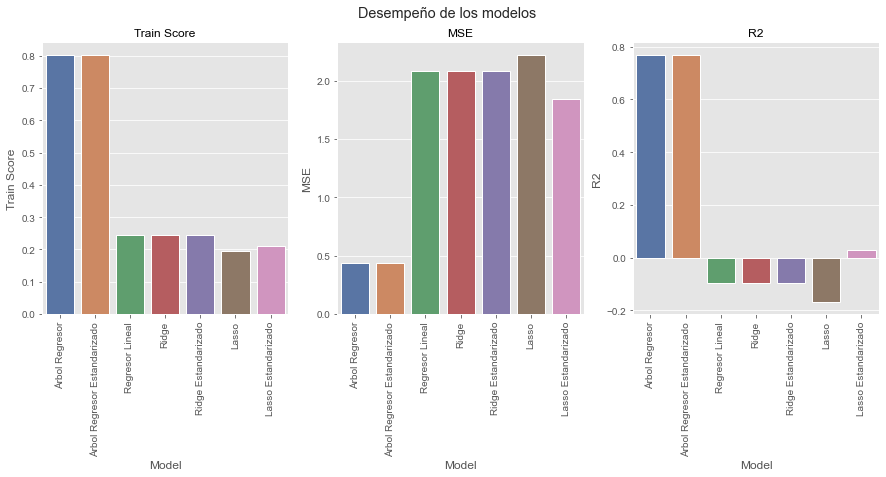

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.figuresize = (20, 8)
sns.set()
sns.barplot(x='Model', y='Train Score', data=results_df, ax=axes[0])
sns.barplot(x='Model', y='MSE', data=results_df, ax=axes[1])
sns.barplot(x='Model', y='R2', data=results_df, ax=axes[2])

titles = ['Train Score', 'MSE', 'R2']

for ax, title in zip(axes, titles):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(title)

fig.suptitle('Desempeño de los modelos');


Después de estas pruebas iniciales vemos que los modelos lineales no son capaces de capturar las relaciones que hay entre las variables numéricas de la base de datos y el `Revenue` logrado; el único regresor que tuvo un desempeño prometedor fue el árbol de decisión. De ahora en adelante nos enfocaremos en optimizar este método, encontrando los parámetros que maximicen su poder predictivo.

> Como nota, el modelo de regresión lineal con datos estandarizados no fue incluido en la visualización anterior. El error cuadrado medio de este modelo era tan grande que no dejaba visualizar los resultados de los demás modelos.

## Reducción de dimensionalidad

La visualización anterior compara las medidas de desempeño para nuestros modelos iniciales usando el `dataframe` que contiene las 20 variables nuevas. Este conjunto de datos fue a su vez usado estandarizado y sin estandarizar. Ahora que ya sabemos que de entre todos, los árboles de decisión regresores que usan datos estandarizados son los que tienen un mejor desempeño, podemos enfocarnos en verificar si es que podemos reducir el número de variables que los modelos utilicen.

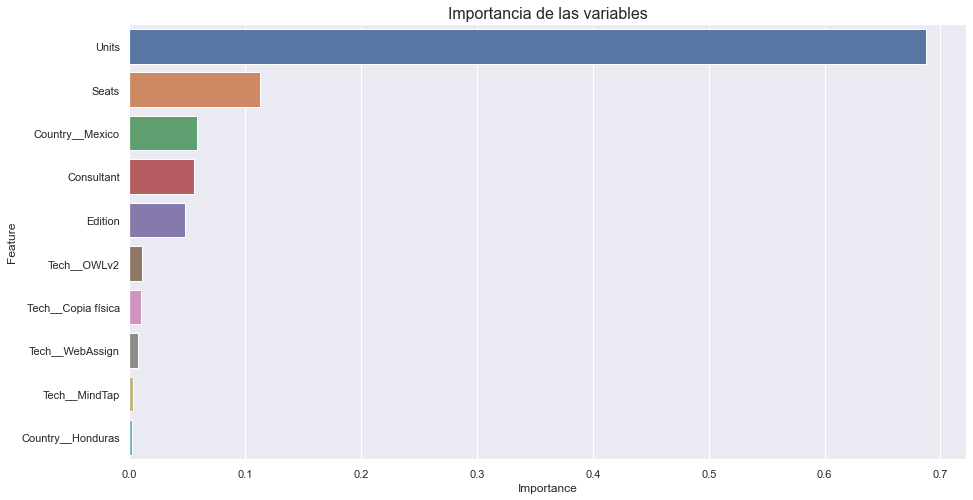

In [21]:
importances = tree_2.feature_importances_
names = test_cols
n = 10
importances_df = pd.DataFrame({'Feature': names, 'Importance': importances}).sort_values('Importance', ascending=False)
top_n_features = importances_df.head(n)

plt.figure(figsize=(15,8))
sns.barplot(x='Importance', y='Feature', data=top_n_features, palette='deep')
plt.title('Importancia de las variables', fontsize=16);


Vemos que la mayoría de las variables no tienen mucha importancia para el modelo en general. Podemos descartar la mayoría y solamente quedarnos con unas cuantas. Como equipo proponemos quedarnos con las mejores 5:

1. Units
2. Seats
3. Country__Mexico
4. Consultant
5. Edition

Los valores de importancia representados en la gráfica anterior son una representación directa del valor predictivo que tienen para el árbol regresor.

## Validación Cruzada

Para este punto de nuestro trabajo de investigación ya hemos comprobado que el `Revenue` no puede ser modelado como una relación lineal de las variables que se encuentran en las bases de datos. De nuestros resultados experimentales hemos visto que un árbol de decisión regresor es quien suele tener un desempeño mayor.

Ahora que nos hemos centrado en un tipo de modelo, podemos comenzar a hacer una validación cruzada en conjunto de un `GridSearch`. Usando estas 2 herramientas podremos encontrar cómo se comporta en promedio este modelo predictivo, además de que sabremos cuáles son los hiperparámetros que mejor se ajustan al `Revenue`. Como número de $\text{k-folds}$ usaremos el estándar general de 5, aumentar este valor nos permitiría obtener una métrica más precisa del comportamiento promedio del modelo, pero requeriría de más tiempo hacer la operación.

In [22]:
testing_df = country_dum

X = testing_df[['Units', 'Seats', 'Country__Mexico', 'Consultant', 'Edition']]
y = testing_df['Log Revenue']

# Estandarizar los datos X
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)


Como nota, no estamos usando la columna del `Revenue` directamente, sino que hemos optado por usar el logaritmo de este. La variable de `Revenue` tiene una dispersión muy alta que un modelo regresor no podrá capturar tan fácilmente, al transformar esta columna con el logaritmo natural hemos reducido el grado de dispersión, facilitando así la predicción de este valor.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=0)


In [24]:
from sklearn.model_selection import GridSearchCV


In [25]:
param_grid = {'max_depth': [i for i in range(1, 20)], 'splitter': ['best', 'random'], 'random_state': [0]}
clf = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='r2', )


In [26]:
clf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='r2')

In [27]:
print(f'''Mejor modelo:.
Mejores parámetros: {clf.best_params_}
Mejor puntaje: {clf.best_score_ * 100:.2f}%
MSE: {mean_squared_error(y_test, clf.predict(X_test))}
Promedio de scores: {np.mean(clf.cv_results_['mean_test_score']) * 100:.2f}%''')


Mejor modelo:.
Mejores parámetros: {'max_depth': 19, 'random_state': 0, 'splitter': 'best'}
Mejor puntaje: 75.82%
MSE: 0.4030359898148961
Promedio de scores: 58.16%


In [28]:
best_tree = clf.best_estimator_
best_tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=19, random_state=0)

Después de realizar la validación cruzada y el `GridSearch`, encontramos que en promedio un árbol de decisión regresor tendrá un puntaje de 58.16%, y que la mejor variante de árbol de decisión regresor es aquella que tiene una máxima profundidad de 19, su coeficiente de determinación es de 75.82%

Con este modelo CENGAGE podría atribuir el 75.82% de sus ganancias generadas a las predicciones del modelo.

## `Revenue` predicho por el modelo

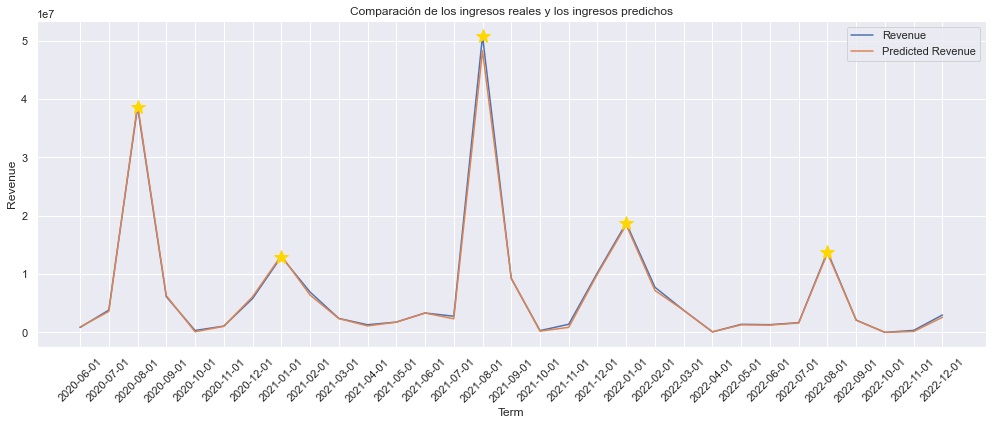

In [29]:
rev_pred = np.exp(best_tree.predict(scaler.fit_transform(X)))
# Add the predicted revenue to the dataframe
country_dum['Predicted Revenue'] = rev_pred

from scipy.signal import find_peaks

plt.figure(figsize=(17, 6))
agg_revenue_term = country_dum.groupby('Term').sum()['Revenue']
predicted_agg_revenue_term = country_dum.groupby('Term').sum()['Predicted Revenue']
ax = sns.lineplot(x=agg_revenue_term.index, y=agg_revenue_term, label='Revenue')
ax2 = sns.lineplot(x=predicted_agg_revenue_term.index, y=predicted_agg_revenue_term, label='Predicted Revenue')
plt.xticks(agg_revenue_term.index, rotation=45)

# Encontrar los máximos locales
peaks, _ = find_peaks(agg_revenue_term, distance=5)
# Plot the peaks
plt.plot(agg_revenue_term.index[peaks],
         agg_revenue_term[peaks], "*", markersize=15, color='gold')

ax.set_title('Comparación de los ingresos reales y los ingresos predichos');


## Conclusiones

Respecto al entrenamiento de diferentes modelos predictivos podemos decir que la relación que existe entre las variables de la base de datos es de un carácter no lineal, por lo que en general, modelos que tengan este formato no se desempeñarán de manera óptima.

Después de nuestro proceso de investigación hemos encontrado que un árbol de decisión regresor con profundidad máxima de 19 tiene la mejor capacidad de predecir el `Revenue` generado por una operación dada. El modelo que encontramos tiene un coeficiente de determinación $R_2$ de 0.7582, y $MSE$ (error cuadrático medio) de 0.403.

Como recordatorio, tiene que hacerse una transformación de la predicción generada por el modelo, actualmente los datos que regresa la predicción son valores logarítmicos, las ganancias predichas deben de ser exponenciadas para obtener las ganancias reales.